<a href="https://colab.research.google.com/github/kadygithub/Colab_MNIST_Akram_Tensorflow/blob/master/colab_MNIST_AKRAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf


# Helper libraries
import numpy
import matplotlib.pyplot as plt
from scipy import ndimage
from six.moves import urllib

import gzip
import os

class Data_Mnist:
  def __init__(self):
    self.SOURCE = 'http://yann.lecun.com/exdb/mnist/'
    self.DATA_DIR= "data"
    self.IMAGE_SIZE = 28
    self.CHANNELS = 1
    self.INTENSITY = 255
    self.LABELS = 10
    self.filepath=""
    # number of the validation  data images.
    self.SIZE_VALIDATION= 5000  

# import data
  def import_data(self,filename):
      #check the DATA_DIR, if data dose not exist,make directory and then download data!
      if not tf.gfile.Exists(self.DATA_DIR):
          tf.gfile.MakeDirs(self.DATA_DIR)
      filepath = os.path.join(self.DATA_DIR, filename)
      if not tf.gfile.Exists(filepath):
          filepath, _ = urllib.request.urlretrieve(self.SOURCE + filename, filepath)
          print('data downloaded')
      
      return filepath
  def pull_images(self,filename, num_images):
    """First we pull the images into a 4D tensor [image_index, y, x, channels] 
      then flatten out the later 3 dimensions[image_index, y*x*channels]
    """
   
    print('Extracting', filename)
    with gzip.open(filename) as f:
        k=f.read(16)
        
        
        b = f.read(self.IMAGE_SIZE * self.IMAGE_SIZE * num_images * self.CHANNELS)
        # to use the memory buffer of the data directly
        data = numpy.frombuffer(b, dtype=numpy.uint8).astype(numpy.float32)
        #rescaling values of pixels : [0,255] --> [-.5,5]
        data = data/self.INTENSITY#(data - (self.INTENSITY)) /(2* self.INTENSITY)
        
        data = data.reshape(num_images, self.IMAGE_SIZE, self.IMAGE_SIZE, self.CHANNELS)
        
        # we don't need this layered information (num_images, 28, 28, 1), 
        #so we just flatten out the later 3 dimensions (num_images, 784) 
        data = numpy.reshape(data, [num_images, -1])
    
    return data
  
  def pull_labels(self,filename,num_images):
      # the labels are extracted into a vector"""
      with gzip.open(filename) as f:
          f.read(8)
          b = f.read(1 * num_images)
          labels = numpy.frombuffer(b, dtype=numpy.uint8).astype(numpy.int64)
          num_labels = len(labels)
          encoding= numpy.zeros((num_labels,self.LABELS))
          encoding[numpy.arange(num_labels),labels] = 1
          encoding = numpy.reshape(encoding, [-1, self.LABELS])
          
      return encoding
  def Produce_data(self,data_augmentation_Flag=False):
      # Download data
      train_data = self.import_data('train-images-idx3-ubyte.gz')
      train_labels =self.import_data('train-labels-idx1-ubyte.gz')
      test_data = self.import_data('t10k-images-idx3-ubyte.gz')
      test_labels =self.import_data('t10k-labels-idx1-ubyte.gz')

      # pull images and labels into numpy tensors
      train_data = self.pull_images(train_data,60000)
      print("Training set (images) shape: {shape}".format(shape=train_data.shape))
      train_labels = self.pull_labels(train_labels, 60000)
      print("Training set (labels) shape: {shape}".format(shape=train_labels.shape))
      test_data = self.pull_images(test_data, 10000)
      print("Test set (images) shape: {shape}".format(shape=test_data.shape))
      test_labels = self.pull_labels(test_labels, 10000)
      print("Test set (labels) shape: {shape}".format(shape=test_labels.shape))

      # Set validation data from training data
      validation_data = train_data[:self.SIZE_VALIDATION, :]
      validation_labels = train_labels[:self.SIZE_VALIDATION,:]
      train_data = train_data[self.SIZE_VALIDATION:, :]
      train_labels = train_labels[self.SIZE_VALIDATION:,:]

      #  data_concatenation
      train_data_Total = numpy.concatenate((train_data, train_labels), axis=1)

      train_size = train_data_Total.shape[0]

      return train_data,train_labels,train_data_Total, train_size, validation_data, validation_labels, test_data, test_labels
    

"""  
#d=Data_Mnist()
#train_data,train_labels,train_total_data, train_size, validation_data, validation_labels, test_data, test_labels=d.Produce_data(data_augmentation_Flag=False)
print("Training set (images) shape: {shape}".format(shape=train_data.shape))
print("Training set not include validation(images) shape: {shape}".format(shape=train_total_data.shape))
print( "the images are already rescaled between -0.5 and 0.5, max: ",  numpy.max(train_total_data[0]))
print( "the images are already rescaled between -0.5 and 0.5, min: ",  numpy.min(train_total_data[0]))
"""



 
  

'  \n#d=Data_Mnist()\n#train_data,train_labels,train_total_data, train_size, validation_data, validation_labels, test_data, test_labels=d.Produce_data(data_augmentation_Flag=False)\nprint("Training set (images) shape: {shape}".format(shape=train_data.shape))\nprint("Training set not include validation(images) shape: {shape}".format(shape=train_total_data.shape))\nprint( "the images are already rescaled between -0.5 and 0.5, max: ",  numpy.max(train_total_data[0]))\nprint( "the images are already rescaled between -0.5 and 0.5, min: ",  numpy.min(train_total_data[0]))\n'

In [0]:
def conv2d(x, W, b, strides,padding):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 
def cnn_net(x):
  weights={
    'conv1_filter': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'conv2_filter': tf.get_variable('W1', shape=(3,3,32,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'conv3_filter': tf.get_variable('W2', shape=(5,5,32,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'conv4_filter': tf.get_variable('W3', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'conv5_filter': tf.get_variable('W4', shape=(3,3,64,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'conv6_filter': tf.get_variable('W5', shape=(5,5,64,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wfc': tf.get_variable('W6', shape=(4*4*64,256), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W7', shape=(256,10), initializer=tf.contrib.layers.xavier_initializer()), 
  }
  biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc4': tf.get_variable('B3', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc5': tf.get_variable('B4', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc6': tf.get_variable('B5', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bfc': tf.get_variable('B6', shape=(256), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B7', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}
  conv1 = conv2d(x, weights['conv1_filter'], biases['bc1'],1,'VALID')
  conv1_bn = tf.layers.batch_normalization(conv1)
  conv2 = conv2d(conv1_bn, weights['conv2_filter'], biases['bc2'],1,'VALID')
  conv2_bn = tf.layers.batch_normalization(conv2)
  conv3 = conv2d(conv2_bn, weights['conv3_filter'], biases['bc3'],2,'SAME')
  conv3_bn = tf.layers.batch_normalization(conv3)
  dropl = tf.nn.dropout(conv3_bn,.5)
    
  conv4 = conv2d(dropl, weights['conv4_filter'], biases['bc4'],1,'VALID')
  conv4_bn = tf.layers.batch_normalization(conv4)
  conv5 = conv2d(conv4_bn, weights['conv5_filter'], biases['bc5'],1,'VALID')
  conv5_bn = tf.layers.batch_normalization(conv5)
  conv6 = conv2d(conv5_bn, weights['conv6_filter'], biases['bc6'],2,'SAME')
  conv6_bn = tf.layers.batch_normalization(conv6)
  drop2 = tf.nn.dropout(conv6_bn, .5)  # drop out is set to 0.7
    
  # Fully connected layer
  # Reshape conv2 output to fit fully connected layer input
  fc1 = tf.reshape(drop2, [-1, weights['wfc'].get_shape().as_list()[0]])
  fc1 = tf.add(tf.matmul(fc1, weights['wfc']), biases['bfc'])
  fc1 = tf.nn.relu(fc1)
  # Output, class prediction
  # finally we multiply the fully connected layer with the weights and add a bias term. 
  fc1_bn = tf.layers.batch_normalization(fc1)
  drop_fc = tf.nn.dropout(fc1_bn, .5)
  out = tf.add(tf.matmul(drop_fc, weights['out']), biases['out'])
  return out
    
    

  

Extracting data/train-images-idx3-ubyte.gz
Training set (images) shape: (60000, 784)
Training set (labels) shape: (60000, 10)
Extracting data/t10k-images-idx3-ubyte.gz
Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000, 10)
validation_data (5000, 784)
validation_labels (5000, 10)


/usr/local/lib/python2.7/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Iter 0, Loss= 0.028004, Training Accuracy= 0.99219
Epoch: 0001, Validation Accuracy: 0.96220
Epoch: 0001, test Accuracy: 0.96470
Iter 1, Loss= 0.012800, Training Accuracy= 1.00000
Epoch: 0002, Validation Accuracy: 0.97520
Epoch: 0002, test Accuracy: 0.97550
Iter 2, Loss= 0.013755, Training Accuracy= 0.99219
Epoch: 0003, Validation Accuracy: 0.97840
Epoch: 0003, test Accuracy: 0.97790
Iter 3, Loss= 0.002865, Training Accuracy= 1.00000
Epoch: 0004, Validation Accuracy: 0.98480
Epoch: 0004, test Accuracy: 0.98350
Iter 4, Loss= 0.007280, Training Accuracy= 1.00000
Epoch: 0005, Validation Accuracy: 0.98260
Epoch: 0005, test Accuracy: 0.98480
Iter 5, Loss= 0.007835, Training Accuracy= 1.00000
Epoch: 0006, Validation Accuracy: 0.98520
Epoch: 0006, test Accuracy: 0.98310
Iter 6, Loss= 0.000617, Training Accuracy= 1.00000
Epoch: 0007, Validation Accuracy: 0.98580
Epoch: 0007, test Accuracy: 0.98600
Iter 7, Loss= 0.004200, Training Accuracy= 1.00000
Epoch: 0008, Validation Accuracy: 0.98400
Epoc

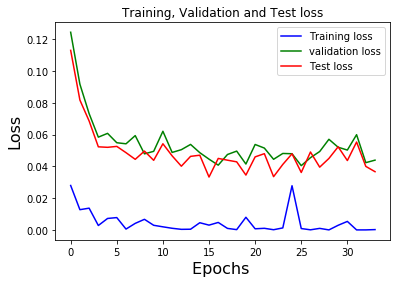

<Figure size 432x288 with 0 Axes>

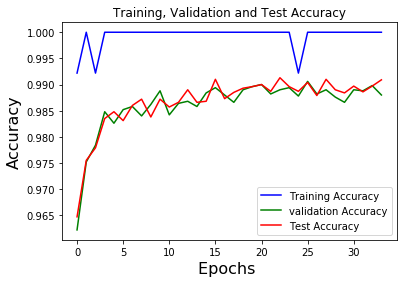

<Figure size 432x288 with 0 Axes>

In [5]:

tf.reset_default_graph() 
# Training Phase
save_model_path = "model/model.ckpt"



# Hyper parameters for train
epochs = 34 # 10 for augmented training data, 20 for training data
TRAIN_BATCH_SIZE = 128
keep_probability = 0.7
display_status_step = 100
validation_step = 500
learning_rate = 0.001

# Hyper parameters for test
TEST_BATCH_SIZE = 5000
 
def train():
  d=Data_Mnist()
  train_data,train_labels,train_total_data, train_size, validation_data, validation_labels, test_data, test_labels=d.Produce_data(data_augmentation_Flag=False)
  
  train_X = train_data.reshape(-1, 28, 28, 1)
  test_X = test_data.reshape(-1,28,28,1)
  validation_X = validation_data.reshape(-1,28,28,1)
  print("validation_data",validation_data.shape)
  print("validation_labels",validation_labels.shape)
  train_y = train_labels
  test_y = test_labels
  validation_y = validation_labels

  #both placeholders are of type float
  x = tf.placeholder("float", [None, 28,28,1])
  y = tf.placeholder("float", [None, 10]) 
  pred = cnn_net(x)

  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
  #Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
  correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

  #calculate accuracy across all the given images and average them out. 
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  saver = tf.train.Saver()
  sess = tf.InteractiveSession()
  init = tf.global_variables_initializer()
  with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    validation_accuracy=[]
    validation_loss=[]
    max_acc = 0.
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(epochs):
        for batch in range(len(train_X)//TRAIN_BATCH_SIZE):
            batch_x = train_X[batch*TRAIN_BATCH_SIZE:min((batch+1)*TRAIN_BATCH_SIZE,len(train_X))]
            batch_y = train_y[batch*TRAIN_BATCH_SIZE:min((batch+1)*TRAIN_BATCH_SIZE,len(train_y))]    
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        

        
        # Calculate accuracy for all 10000 mnist validation images
        
        validation_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: validation_X,y : validation_y})
        print("Epoch:", '%04d,' % (i + 1),"Validation Accuracy:","{:.5f}".format(validation_acc))
        
        if validation_acc > max_acc:
          max_acc = validation_acc
          save_path = saver.save(sess, save_model_path)
          #print("Model updated and saved in file: %s" % save_path)
        
        test_acc1,test_loss1 = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        print("Epoch:", '%04d,' % (i + 1),"test Accuracy:","{:.5f}".format(test_acc1))
        
        
        train_loss.append(loss)
        validation_loss.append(valid_loss)
        train_accuracy.append(acc)
        validation_accuracy.append(validation_acc)
        test_loss.append(test_loss1)
        test_accuracy.append(test_acc1)
        
    print("Adam Optimization process Finished!")   
    #test the model
    
    # Restore variables 
    saver.restore(sess, save_model_path)

    # Calculate accuracy for all mnist test images
    test_size = test_labels.shape[0]
    batch_size = TEST_BATCH_SIZE
    total_batch = int(test_size / batch_size)

    acc_buffer = []

    # Loop over all batches
    for i in range(total_batch):
        # Compute the offset of the current minibatch in the data.
        offset = (i * batch_size) % (test_size)
        batch_xs = test_X[offset:(offset + batch_size), :]
        batch_ys = test_y[offset:(offset + batch_size), :]

        y_final = sess.run(pred, feed_dict={x: batch_xs, y: batch_ys})
        correct_prediction = numpy.equal(numpy.argmax(y_final, 1), numpy.argmax(batch_ys, 1))
        acc_buffer.append(numpy.sum(correct_prediction) / batch_size)

    print("test accuracy for the stored model: %g" % numpy.mean(acc_buffer))
    plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
    plt.plot(range(len(train_loss)), validation_loss, 'g', label='validation loss')
    plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
    plt.title('Training, Validation and Test loss')
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.legend()
    plt.figure()
    plt.show()   
    plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
    plt.plot(range(len(train_loss)), validation_accuracy, 'g', label='validation Accuracy')
    plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
    plt.title('Training, Validation and Test Accuracy')
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.legend()
    plt.figure()
    plt.show()
    summary_writer.close()
train()

Training  the CNN for Mnist data :
